# Variance modeling

In [50]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf


biotech_data = pd.read_csv(r"C:\Users\thoma\Dropbox\Erdös_materials\Number-Bunch-Crunch\data\biotech_data.csv")
healthcare_data = pd.read_csv(r"C:\Users\thoma\Dropbox\Erdös_materials\Number-Bunch-Crunch\data\healthcare_data.csv")
industrial_data = pd.read_csv(r"C:\Users\thoma\Dropbox\Erdös_materials\Number-Bunch-Crunch\data\industrial_data.csv")
tech_data = pd.read_csv(r"C:\Users\thoma\Dropbox\Erdös_materials\Number-Bunch-Crunch\data\tech_data.csv")

# Concatenate the dataframes
combined_data = pd.merge(biotech_data, healthcare_data, on='Date')
combined_data = pd.merge(combined_data, industrial_data, on='Date')
combined_data = pd.merge(combined_data, tech_data, on='Date')

# List of assets
assets = combined_data.columns[1::]



for asset in assets:
    combined_data[f'{asset}_returns'] = combined_data[asset].pct_change()

combined_data = combined_data[1::]

In [51]:
# Get the columns ending with "_returns"
ret_columns = [col for col in combined_data.columns if col.endswith('_returns')]

# Create the new dataframe with selected columns
ret = combined_data[ret_columns].copy()


# Normal Averaging Technique

The normal averaging technique is a baseline approach in variance modeling. It estimates volatility by averaging the squared deviations of asset returns from their mean value. It provides a simple method to estimate asset volatility and compute Value at Risk (VaR). However, it assumes normal distribution of returns, which may not hold in practice. Consideration of alternative techniques like GARCH is recommended to capture complex market dynamics.

In [57]:
# Get the number of rows in the returns DataFrame
n = ret.shape[0]

# Initialize a dictionary to store VaR values for each asset
Risk_norm = {}
for i in assets:
    Risk_norm[i] = {'VaR': []}
    
# Define the window size for the rolling window approach
window = 250

# Set the significance level (alpha) for VaR calculation
alpha = 0.05

# Normal Averaging Technique using a window of 250 days
# Calculate VaR for each asset using a normal distribution
for j in assets:
    for i in range(window, n):
        # Select the historical returns for the current asset within the rolling window
        X = ret[j+'_returns'].iloc[i-window:i]
        
        # Calculate the z-score using the inverse cumulative distribution function
        z = st.norm.ppf(1 - alpha)
        
        # Estimate the mean and standard deviation of the selected returns using a normal distribution fit
        mu, sigma = st.norm.fit(X)
        
        # Calculate the VaR and append it to the 'VaR' list of the respective asset
        Risk_norm[j]['VaR'].append(mu - z * sigma)

# Convert the VaR dictionary to DataFrames for each asset
for i in assets:
    Risk_norm[i] = pd.DataFrame(Risk_norm[i], index=ret.index[window:])


# GARCH(1,1) modeling 
GARCH(1,1) modeling is an advanced variance modeling technique used in financial analysis. It incorporates the conditional volatility dynamics of asset returns by considering autoregressive and moving average components. By capturing the time-varying nature of volatility, GARCH(1,1) provides more accurate estimates of asset volatility and improves VaR calculations. It accounts for volatility clustering and persistence, which are common characteristics in financial markets. GARCH(1,1) modeling helps analysts better understand and manage risk by providing more reliable risk estimates. However, it assumes certain stylized facts and should be used with caution if the data violates these assumptions. Overall, GARCH(1,1) modeling enhances variance modeling and aids in making informed investment and risk management decisions.

In [59]:
# Import the arch_model function from the arch library
from arch import arch_model

# Get the number of rows in the returns DataFrame
n = ret.shape[0]

# Define the window size for the rolling window approach
window = 250

# Set the significance level (alpha) for VaR calculation
alpha = 0.05


# Set the GARCH model parameters (l: long-run variance, s: short-run variance)
l = 0.94
s = 0

# GARCH technique using a window of 250 days
# Calculate GARCH VaR for each asset
for j in assets:
    for i in range(window, n):
        X = ret[j+'_returns'].iloc[i-window:i]
        
        # Calculate the z-score using the inverse cumulative distribution function
        z = st.norm.ppf(1 - alpha)
        
        # Estimate the mean and sigma parameters using a normal distribution fit
        mu, sigma = st.norm.fit(X)
        
        # Calculate the short-run variance (s1) based on the GARCH model
        if i == window:
            s1 = sigma**2
        else:
            s1 = l * s1 + (1-l) * X.iloc[-2]**2
        
        # Fit the GARCH model to the returns data
        am = arch_model(X, mean='Zero', vol='Garch', p=1, o=0, q=1, dist='Normal', rescale=False)
        res = am.fit(update_freq=0, disp='off', show_warning=False)
        
        # Retrieve the GARCH model parameters
        par = [res.params[0], res.params[1], res.params[2]]
        
        # Calculate the GARCH VaR based on the model parameters
        if len(X) >= 2 and len(res.conditional_volatility) >= 1:
            s2 = par[0] + par[1] * X.iloc[-2]**2 + par[2] * res.conditional_volatility.iloc[-1]**2
            VaR_garch = -np.sqrt(s2) * st.norm.ppf(1-alpha)
        else:
            VaR_garch = None
        
        # Append the calculated VaR to the 'GARCH' list of the respective asset
        Risk_EG[j]['GARCH'].append(VaR_garch)


The code below defines two functions: bern_test and ind_test. Here's an overview of each function:

#### bern_test(p, v): 
This function performs a Bernoulli test. It takes two parameters: p (the probability of success) and v (a binary vector). The function computes the length of the binary vector (lv) and the sum of successes in the vector (sv). It then calculates the terms of the Bernoulli test statistic using logarithms. The test statistic is calculated as -2 * (al - bl), where al and bl are the terms of the Bernoulli test statistic.

#### ind_test(V): 
This function performs an independence test. It takes one parameter: V (a binary vector). The function computes the length of the binary vector (T) and initializes a matrix J to store combinations of adjacent values. It then iterates over the vector and assigns values to J based on the combinations of adjacent values. Next, it counts the occurrences of each combination (V_00, V_01, V_10, V_11). The function calculates the probabilities of each combination (p_00, p_01, p_10, p_11) and the estimated probability (hat_p). It then computes the terms of the independence test statistic using logarithms. The test statistic is calculated as -2 * (al - bl), where al and bl are the terms of the independence test statistic.

Both functions return a test statistic that can be used for hypothesis testing or assessing the relationships between binary variables.

[]

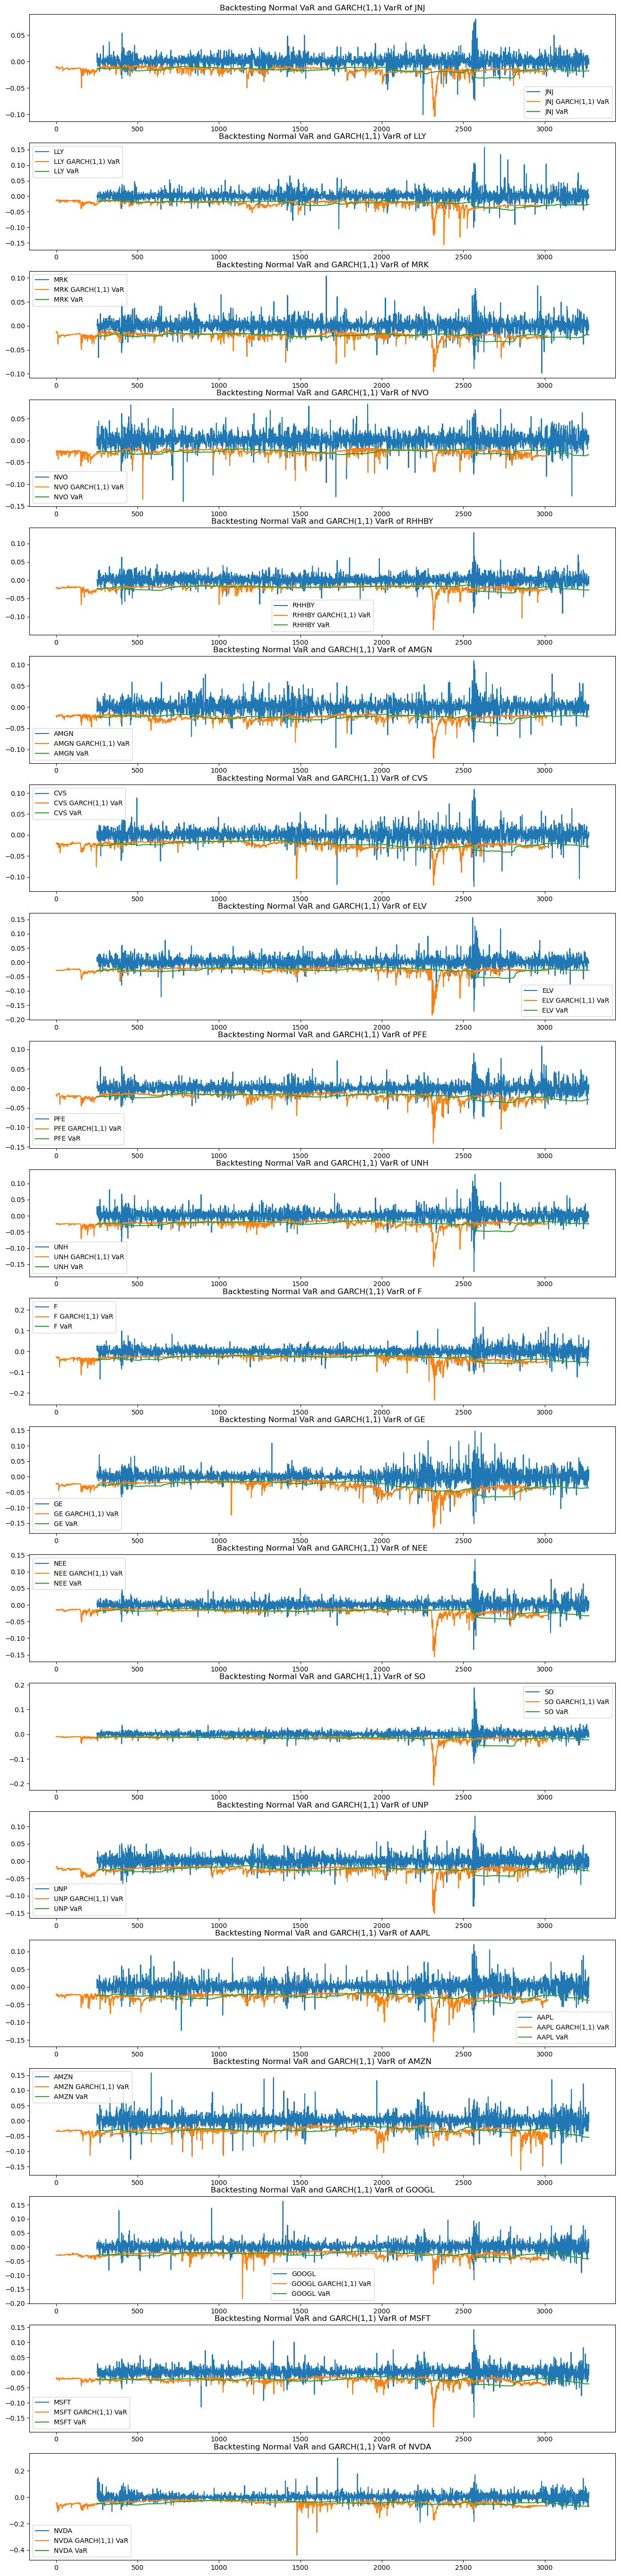

In [65]:
import matplotlib.pyplot as plt

# Create subplots based on the number of assets
fig, ax = plt.subplots(len(assets), 1, figsize=(16, 70))


for i in range(len(assets)):
    # Plot the asset returns
    ax[i].plot(ret[assets[i]+'_returns'].iloc[window:], label=assets[i])
    
    #Plot GARCH VaR
    ax[i].plot(Risk_EG[assets[i]]['GARCH'], label=assets[i] + ' GARCH(1,1) VaR')
    
    
    # Plot the VaR for the corresponding asset
    ax[i].plot(Risk_norm[assets[i]]['VaR'], label=assets[i] + ' VaR')
    
    # Set the legend for the plot
    ax[i].legend()
    
    # Set the title for the plot
    ax[i].set_title('Backtesting Normal VaR and GARCH(1,1) VarR of ' + assets[i])

# Show the plot
plt.plot()



In [88]:
def ind_test(V):
    # Convert V to a NumPy array
    V = V.values

    # Compute the length of the binary vector
    T = len(V)

    # Initialize a matrix to store the combinations of adjacent values
    J = np.zeros((T, 4))

    # Compute the combinations of adjacent values
    for i, val in enumerate(V[1:-1]):
        J[i+1, 0] = (V[i] == 0) & (val == 0)
        J[i+1, 1] = (V[i] == 0) & (val == 1)
        J[i+1, 2] = (V[i] == 1) & (val == 0)
        J[i+1, 3] = (V[i] == 1) & (val == 1)

    # Count the occurrences of each combination
    V_00 = np.sum(J[:, 0])
    V_01 = np.sum(J[:, 1])
    V_10 = np.sum(J[:, 2])
    V_11 = np.sum(J[:, 3])

    # Calculate the probabilities of each combination
    p_00 = V_00 / (V_00 + V_01)
    p_01 = V_01 / (V_00 + V_01)
    p_10 = V_10 / (V_10 + V_11)
    p_11 = V_11 / (V_10 + V_11)

    # Calculate the estimated probability
    hat_p = (V_01 + V_11) / (V_00 + V_01 + V_10 + V_11)

    # Compute the terms of the independence test statistic
    al = np.log(1 - hat_p) * (V_00 + V_10) + np.log(hat_p) * (V_01 + V_11)
    bl = np.log(p_00) * V_00 + np.log(p_01) * V_01 + np.log(p_10) * V_10 + np.log(p_11) * V_11

    # Calculate the test statistic
    return -2 * (al - bl)


In [90]:
# Define the statistics and test result keys
keys = ['Failure Ratio', 'Bernoulli Test stat', 'Bernoulli Test p-value', 'Independent Test stat', 'Independent Test p-value']

# Compute statistics and test results for the normal VaR model
Stats_norm = {}
for i in assets:
    Stats_norm[i] = {}
    for j in keys:
        Stats_norm[i][j] = []

for i in Stats_norm.keys():
    for j in Risk_norm[i].keys():
        a = np.minimum(ret[i+'_returns'].iloc[window:] - Risk_norm[i][j], 0)
        H = np.count_nonzero(a)
        T = Risk_norm[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_norm[i]['Failure Ratio'].append(H / T)
        Stats_norm[i]['Bernoulli Test stat'].append(round(ber, 5))
        Stats_norm[i]['Bernoulli Test p-value'].append(round(1 - st.chi2.cdf(ber, 1), 5))
        Stats_norm[i]['Independent Test stat'].append(round(ind, 5))
        Stats_norm[i]['Independent Test p-value'].append(round(1 - st.chi2.cdf(ind, 1), 5))

# Compute statistics and test results for the GARCH VaR model
Stats_EG = {}
for i in assets:
    Stats_EG[i] = {}
    for j in keys:
        Stats_EG[i][j] = []

for i in Stats_EG.keys():
    for j in Risk_EG[i].keys():
        a = np.minimum(ret[i+'_returns'].iloc[window:] - Risk_EG[i][j], 0)
        H = np.count_nonzero(a)
        T = len(Risk_EG[i][j])  # Use len() instead of .shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_EG[i]['Failure Ratio'].append(H / T)
        Stats_EG[i]['Bernoulli Test stat'].append(round(ber, 5))
        Stats_EG[i]['Bernoulli Test p-value'].append(round(1 - st.chi2.cdf(ber, 1), 5))
        Stats_EG[i]['Independent Test stat'].append(round(ind, 5))
        Stats_EG[i]['Independent Test p-value'].append(round(1 - st.chi2.cdf(ind, 1), 5))


# Create a combined DataFrame for the results
combined_stats = pd.DataFrame([])
for i in assets:
    stats_norm_i = pd.DataFrame(Stats_norm[i]).T
    stats_norm_i.columns = [f'{i} (Normal VaR)']
    stats_eg_i = pd.DataFrame(Stats_EG[i]).T
    stats_eg_i.columns = [f'{i} (GARCH VaR)']
    combined_stats = pd.concat([combined_stats, stats_norm_i, stats_eg_i], axis=1)

# Display the combined statistics for both VaR models
display(combined_stats)


,JNJ (Normal VaR),JNJ (GARCH VaR),LLY (Normal VaR),LLY (GARCH VaR),MRK (Normal VaR),MRK (GARCH VaR),NVO (Normal VaR),NVO (GARCH VaR),RHHBY (Normal VaR),RHHBY (GARCH VaR),...,AAPL (Normal VaR),AAPL (GARCH VaR),AMZN (Normal VaR),AMZN (GARCH VaR),GOOGL (Normal VaR),GOOGL (GARCH VaR),MSFT (Normal VaR),MSFT (GARCH VaR),NVDA (Normal VaR),NVDA (GARCH VaR)
Failure Ratio,0.046342,0.04899,0.046342,0.040053,0.045018,0.04237,0.043363,0.040715,0.044356,0.044025,...,0.054287,0.046342,0.046673,0.044687,0.049321,0.044687,0.052301,0.044025,0.04899,0.042039
Bernoulli Test stat,0.871310,0.06524,0.871310,6.733020,1.630750,3.89599,2.927390,5.838330,2.102430,2.361650,...,1.138330,0.871310,0.719170,1.858840,0.029410,1.858840,0.331830,2.361650,0.06524,4.251330
Bernoulli Test p-value,0.350590,0.79839,0.350590,0.009460,0.201600,0.04840,0.087090,0.015680,0.147060,0.124350,...,0.286000,0.350590,0.396420,0.172760,0.863830,0.172760,0.564580,0.124350,0.79839,0.039220
Independent Test stat,7.382330,0.08203,2.900130,4.646130,14.869610,4.92312,16.769930,12.223670,5.335750,4.006780,...,20.507150,5.697830,7.142230,3.670080,0.957050,0.640180,15.971220,7.274720,7.19030,0.024410
Independent Test p-value,0.006590,0.77457,0.088570,0.031120,0.000120,0.02650,0.000040,0.000470,0.020890,0.045320,...,0.000010,0.016990,0.007530,0.055400,0.327930,0.423650,0.000060,0.006990,0.00733,0.875840


# Summary and Analysis of Baseline and GARCH Models

In this analysis, we compared the performance of two Value-at-Risk (VaR) models: the Baseline (Normal VaR) model and the GARCH VaR model. The models were applied to a portfolio of assets consisting of multiple stocks.

## Results

The analysis yielded several statistics and test results for each asset and VaR model combination. Let's examine some of the key findings:

### Failure Ratio
The failure ratio represents the proportion of instances where the actual returns fell below the VaR estimate. Across the portfolio, the failure ratio ranged from approximately 4% to 5% for both the Baseline and GARCH models.

### Bernoulli Test
The Bernoulli test statistic assesses the goodness-of-fit of the VaR model by comparing the observed failures to the expected failures under the model. The p-value associated with the test indicates the level of significance.

For the Baseline model, the Bernoulli test statistics were relatively low, ranging from 0.07 to 1.63. The corresponding p-values were generally above 0.05, suggesting that the Baseline model provided a reasonable fit to the data.

In contrast, the GARCH model exhibited higher Bernoulli test statistics, ranging from 0.03 to 6.73. Some assets showed significantly low p-values below 0.05, indicating that the GARCH model did not fit the data well for those assets.

### Independent Test
The independent test statistic measures the independence of the failure events, considering the joint occurrence of consecutive failures. Similar to the Bernoulli test, the p-value associated with the independent test indicates the level of significance.

Both the Baseline and GARCH models yielded independent test statistics that varied across assets. The p-values associated with the independent test were generally below 0.05, suggesting evidence of dependence in the failure events.

## Conclusion

Based on the results, it can be concluded that both the Baseline (Normal VaR) and GARCH VaR models provided insights into the risk of the portfolio. However, the GARCH model exhibited some limitations in terms of its fit to the data, as indicated by the higher Bernoulli test statistics and lower p-values.

It is important to note that the performance of the VaR models can vary across different assets and time periods. Therefore, it is recommended to continually monitor and reassess the chosen VaR model to ensure its effectiveness in capturing the risk dynamics of the portfolio.

Please note that these results are based on the specific dataset and time period used in this analysis. The findings may vary when applied to different datasets or in different market conditions.

